In [2]:
# Dependencies
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from utils.string_utils import datetime_to_str
from utils.config import load_config_nb
from utils.policies import load_policy
from nocturne.envs.base_env import BaseEnv

sns.set('notebook', font_scale=1.15, rc={'figure.figsize': (6, 3)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

### Configurations

In [3]:
BASE_PATH = '../models/il'

env_config = load_config_nb('env_config')

env_config.data_path = f'../{env_config.data_path}'
env_config.max_num_vehicles = 1
env_config.num_files = 100

### Make env

In [4]:
# Make env
env = BaseEnv(env_config)

### Metrics

In [5]:
# Entropy
from scipy.stats import entropy

env.action_space

Discrete(651)

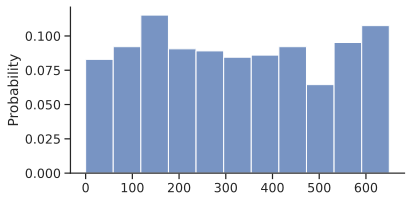

In [6]:
samples = np.random.choice(env.action_space.n, 651)

sns.histplot(samples, kde=False, stat='probability')
sns.despine()

In [7]:
# Upper bound on the entropy for this action space: Maximum uncertainty
entropy(samples)

6.285060464105374

### Policies

In [8]:
# Load trained human reference policy
human_policy = load_policy(
    data_path=BASE_PATH,
    file_name='human_policy_D651_S500_02_18_20_05_AV_ONLY', 
)

In [84]:
r1 = 0 # Create uniform random numbers in half-open interval [2.0, 5.0)
r2 = 651

num_samples = 651

samples = torch.randint(low=r1, high=r2, size=(num_samples,))
pi_dist_early = samples / samples.sum()

In [85]:
obs_dict = env.reset()
controlled_agent = env.controlled_vehicles[0]

print(f'controlling {len(env.controlled_vehicles)} vehicle(s) with id {controlled_agent.id}. IS_AV: {controlled_agent.is_av}')

obs = torch.from_numpy(obs_dict[controlled_agent.id]).unsqueeze(dim=0)
act_prob_dist = human_policy.get_distribution(obs).distribution.probs.squeeze().detach().numpy()

controlling 1 vehicle(s) with id 11. IS_AV: True


## 1. IL policy uncertainty

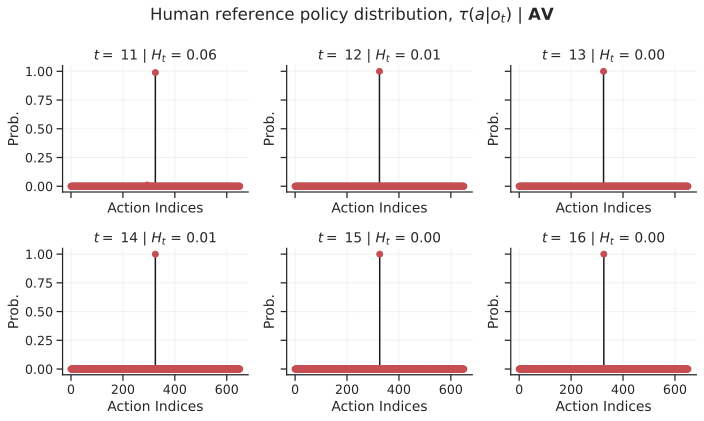

In [22]:
datetime_ = datetime_to_str(dt=datetime.now())
    
# Sample data
num_plots = 6
action_indices = range(651)

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 6), sharey=True, sharex=True)
fig.suptitle(r'Human reference policy distribution, $τ(a | o_t)$ | $\bf{AV}$')

for i in range(num_plots):
    # Get action and distribution (adjust this part according to your actual data retrieval)
    action, _ = human_policy.predict(obs, deterministic=True)
    action_dict = { controlled_agent.id : int(action[0]) }
    obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
    obs = torch.from_numpy(obs_dict[controlled_agent.id]).unsqueeze(dim=0)
    act_prob_dist = human_policy.get_distribution(obs).distribution.probs.squeeze().detach().numpy()

    # Plot on each subplot
    ax = axs[i // 3, i % 3]

    ax.set_title(f'$t =$ {env.step_num} | $H_t$ = {entropy(act_prob_dist):.2f}')
    ax.stem(action_indices, act_prob_dist, linefmt='k-', markerfmt='ro', basefmt='r')
    ax.set_xlabel('Action Indices')
    ax.set_ylabel('Prob.')
    ax.grid(True, alpha=0.25)
    sns.despine()

plt.tight_layout()

fig.savefig(f'../evaluation/figures/information/example_action_dist_il_{datetime_}.pdf', format='pdf', bbox_inches='tight')

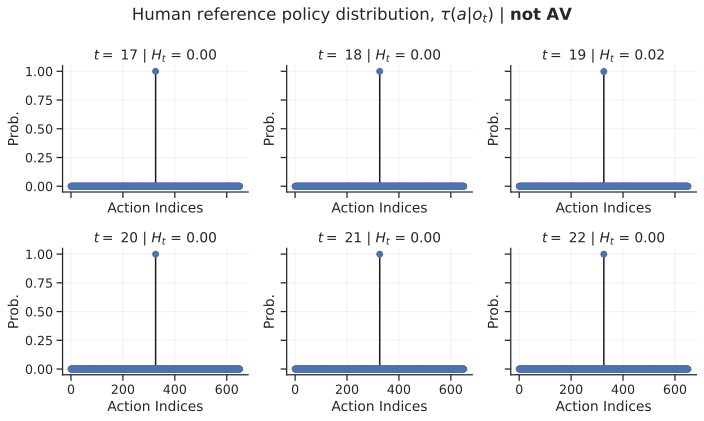

In [23]:
datetime_ = datetime_to_str(dt=datetime.now())
    
# Sample data
num_plots = 6
action_indices = range(651)

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 6), sharey=True, sharex=True)
fig.suptitle(r'Human reference policy distribution, $τ(a | o_t)$ | $\bf{not \,\, AV}$')

for i in range(num_plots):
    # Get action and distribution (adjust this part according to your actual data retrieval)
    action, _ = human_policy.predict(obs, deterministic=True)
    action_dict = { controlled_agent.id : int(action[0]) }
    obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
    obs = torch.from_numpy(obs_dict[controlled_agent.id]).unsqueeze(dim=0)
    act_prob_dist = human_policy.get_distribution(obs).distribution.probs.squeeze().detach().numpy()

    # Plot on each subplot
    ax = axs[i // 3, i % 3]

    ax.set_title(f'$t =$ {env.step_num} | $H_t$ = {entropy(act_prob_dist):.2f}')
    ax.stem(action_indices, act_prob_dist, linefmt='k-', markerfmt='bo', basefmt='b')
    ax.set_xlabel('Action Indices')
    ax.set_ylabel('Prob.')
    ax.grid(True, alpha=0.25)
    sns.despine()

plt.tight_layout()

#fig.savefig(f'../evaluation/figures/information/example_action_dist_il_{datetime_}.pdf', format='pdf', bbox_inches='tight')

### 2. Obtain entropy over distributions

In [24]:
env_config = load_config_nb('env_config')
env_config.max_num_vehicles = 1
env_config.num_files = 500

In [25]:
df = pd.DataFrame(columns=['t', 'agent_type', 'data', 'entropy', 'act_idx', 'prob_sampled_act'])

data_conditions = {'train': '../data/train_no_tl', 'test': '../data/test_no_tl'}
num_episodes = 500

df_idx = 0

 # Run
for dataset in tqdm(data_conditions.keys()):
    
    print(f'Running on {dataset} data')

    # Set data path and make environment
    env_config.data_path = data_conditions[dataset]
    env = BaseEnv(env_config)

    for _ in range(num_episodes):
        
        obs_dict = env.reset()
        controlled_agent = env.controlled_vehicles[0] # Assuming there is only one controlled vehicle
        obs = torch.from_numpy(obs_dict[controlled_agent.id]).unsqueeze(dim=0)
        
        for _ in range(env_config.episode_length):
                    
            # Get action and distribution (adjust this part according to your actual data retrieval)
            action, _ = human_policy.predict(obs, deterministic=False)

            # Take a step
            obs_dict, rew_dict, done_dict, info_dict = env.step({controlled_agent.id : int(action[0])})

            obs = torch.from_numpy(obs_dict[controlled_agent.id]).unsqueeze(dim=0)
            act_prob_dist = human_policy.get_distribution(obs).distribution.probs.squeeze().detach().numpy()        
            
            # Append to dataframe
            df.loc[df_idx] = ({
                't': env.step_num,
                'agent_type': 'av' if controlled_agent.is_av else 'non_av',
                'data': 'train' if env_config.data_path == data_conditions['train'] else 'test',
                'entropy': entropy(act_prob_dist),
                'act_idx': int(action[0]),
                'prob_sampled_act': act_prob_dist[int(action[0])],
            })

            df_idx += 1 
        
            if done_dict["__all__"]: 
                break

  0%|          | 0/2 [00:00<?, ?it/s]

Running on train data


 50%|█████     | 1/2 [00:50<00:50, 50.43s/it]

Running on test data


100%|██████████| 2/2 [01:40<00:00, 50.35s/it]


In [29]:
df.agent_type.value_counts()

agent_type
non_av    36990
av        12530
Name: count, dtype: int64

In [30]:
def mean_plus_min_std(ser: pd.Series, scale: float = 100) -> str:
    return f"{ser.mean():.2f} ± {ser.std():.2f}"

tab = df.pivot_table(
    index=['data', 'agent_type'],
    values=['entropy', 'prob_sampled_act'],
    aggfunc=mean_plus_min_std,
)
#tab.reindex(['train', 'test'], level=0).style.format("{:.2f}")

In [28]:
print(tab.to_latex())

\begin{tabular}{llll}
\toprule
 &  & entropy & prob_sampled_act \\
data & agent_type &  &  \\
\midrule
\multirow[t]{2}{*}{test} & av & 0.26 ± 0.39 & 0.67 ± 0.43 \\
 & non_av & 0.27 ± 0.41 & 0.68 ± 0.42 \\
\cline{1-4}
\multirow[t]{2}{*}{train} & av & 0.08 ± 0.24 & 0.70 ± 0.45 \\
 & non_av & 0.26 ± 0.41 & 0.68 ± 0.42 \\
\cline{1-4}
\bottomrule
\end{tabular}



In [ ]:
# Calculate correlation coefficient
correlation_coefficient = df['entropy'].corr(df['t'])

plt.figure(figsize=(8, 6)) 
# Create the regression plot with adjusted alpha
sns.regplot(data=df, y='entropy', x='t', color="b", line_kws=dict(color="r"), scatter_kws={'alpha': 0.1})

# Add the correlation coefficient and significance to the title
plt.title(f"Correlation: {correlation_coefficient:.2f}, Significance: *")
plt.ylabel('Entropy')

# Show the plot
sns.despine()

#plt.savefig(f'../evaluation/figures/information/corr_ent_time.pdf', format='pdf', bbox_inches='tight')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


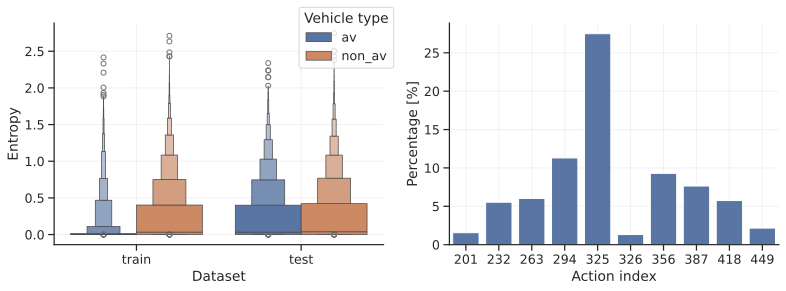

In [70]:
# Group the values by their occurrences and count them
value_counts = df['act_idx'].value_counts()

# Sort the values by their occurrences
sorted_value_counts = value_counts.sort_values(ascending=False)

# Take the top 50 values
top_50 = sorted_value_counts.head(10)
# Calculate the percentage of occurrences
percentage = (top_50 / df['act_idx'].count()) * 100

fig, axs = plt.subplots(1, 2, figsize=(13, 4))

sns.boxenplot(data=df, x='data', y='entropy', hue='agent_type', ax=axs[0], legend=True)
axs[0].set_xlabel('Dataset')
axs[0].set_ylabel('Entropy')
axs[0].grid(True, alpha=0.25)

sns.barplot(x=percentage.index, y=percentage.values, ax=axs[1])
axs[1].set_xlabel('Action index')
axs[1].set_ylabel('Percentage [%]')
axs[1].grid(True, alpha=0.25)

sns.move_legend(axs[0], "upper right", bbox_to_anchor=(1.05, 1.1), title='Vehicle type', facecolor='white')

sns.despine();

fig.savefig(f'../evaluation/figures/information/tau_dists.pdf', format='pdf', bbox_inches='tight')

## 2. KL divergence

In [12]:
# Scipy
from scipy.special import kl_div
from scipy.special import rel_entr as kl_div_diff
# Torch
kl_div_torch = torch.nn.KLDivLoss(reduction="none", log_target=True)

In [13]:
pi_action_dist = torch.tensor([1/3, 1/3, 1/3])

pi_action_dist

tensor([0.3333, 0.3333, 0.3333])

### 2.1 KL early on in training

In [14]:
# Distributions
pi_early = torch.tensor([1/3, 1/3, 1/3])
pi_late = torch.tensor([0.001, 0.8, 0.199])

# IL policy
human_policy = torch.tensor([0.1, 0.7, 0.2])

In [15]:
kl_div_torch(pi_early, human_policy.log()), kl_div_torch(pi_early.log(), human_policy.log()).mean()

(tensor([-0.2636, -0.4830, -0.3886]), tensor(0.0989))

In [16]:
kl_div_torch(pi_early.log(), human_policy.log()), kl_div_torch(pi_early.log(), human_policy.log()).mean()

(tensor([-0.1204,  0.5194, -0.1022]), tensor(0.0989))

In [17]:
kl_div(pi_early, human_policy), kl_div(pi_early, human_policy).mean()

(tensor([0.1680, 0.1194, 0.0369]), tensor(0.1081))

In [114]:
kl_div_diff(pi_early, human_policy), kl_div_diff(pi_early, human_policy).mean()

(tensor([ 0.4013, -0.2473,  0.1703]), tensor(0.1081))

### 2.2 KL later in training

In [115]:
kl_div_torch(pi_late, human_policy), kl_div_torch(pi_late, human_policy).mean()

(tensor([ 0.1094, -0.2014,  0.0012]), tensor(-0.0302))

In [116]:
kl_div(pi_late, human_policy), kl_div(pi_late, human_policy).mean()

(tensor([    0.0944,     0.0068,     0.0000]), tensor(0.0337))

In [117]:
kl_div_diff(pi_late, human_policy), kl_div_diff(pi_late, human_policy).mean()

(tensor([-0.0046,  0.1068, -0.0010]), tensor(0.0337))

### Test

I am doing the following:

---

```Python 
self.reg_loss = torch.nn.KLDivLoss(reduction="batchmean", log_target=True)

# Compute loss
loss_reg = self.reg_loss(
    input=policy_action_dist.log(), target=reg_policy_action_dist.log()
)
```

which computes

```Python
loss_pointwise = target.exp() * (target - input)
```

In [21]:
kl_div_torch_log = torch.nn.KLDivLoss(reduction="batchmean", log_target=True)

In [46]:
# IL policy
human_policy = torch.tensor([0.05, 0.05, 0.9])
pi_action_dist = torch.tensor([1/3, 1/3, 1/3])

# Define the target values
target_values = torch.tensor([0.999, 0.0005, 0.0005])

# Define the number of steps
num_steps = 50

ent_values = []
kl_div_list_pi_tau = []
kl_div_list_tau_pi = []
kl_scipy_list_pi_tau = []

# Compute the increment for each step
increments = (target_values - pi_action_dist) / num_steps

# Iterate for 20 steps
for _ in range(num_steps):
    
    ent_values.append(entropy(pi_action_dist))
    
    kl_mean_tau_pi = float(kl_div_torch_log(human_policy.log(), pi_action_dist.log()).numpy())
    kl_mean_pi_tau = float(kl_div_torch_log(pi_action_dist.log(), human_policy.log()).numpy())
    
    kl_div_list_pi_tau.append(kl_mean_pi_tau)
    kl_div_list_tau_pi.append(kl_mean_tau_pi)
    
    kl_mean_scipy_pi_tau = kl_div(pi_action_dist, human_policy).mean()
    kl_scipy_list_pi_tau.append(kl_mean_scipy_pi_tau)
    
    pi_action_dist += increments    
    
    print(pi_action_dist)

tensor([0.3466, 0.3267, 0.3267])
tensor([0.3600, 0.3200, 0.3200])
tensor([0.3733, 0.3134, 0.3134])
tensor([0.3866, 0.3067, 0.3067])
tensor([0.3999, 0.3000, 0.3000])
tensor([0.4132, 0.2934, 0.2934])
tensor([0.4265, 0.2867, 0.2867])
tensor([0.4398, 0.2801, 0.2801])
tensor([0.4532, 0.2734, 0.2734])
tensor([0.4665, 0.2668, 0.2668])
tensor([0.4798, 0.2601, 0.2601])
tensor([0.4931, 0.2535, 0.2535])
tensor([0.5064, 0.2468, 0.2468])
tensor([0.5197, 0.2401, 0.2401])
tensor([0.5330, 0.2335, 0.2335])
tensor([0.5463, 0.2268, 0.2268])
tensor([0.5597, 0.2202, 0.2202])
tensor([0.5730, 0.2135, 0.2135])
tensor([0.5863, 0.2069, 0.2069])
tensor([0.5996, 0.2002, 0.2002])
tensor([0.6129, 0.1935, 0.1935])
tensor([0.6262, 0.1869, 0.1869])
tensor([0.6395, 0.1802, 0.1802])
tensor([0.6529, 0.1736, 0.1736])
tensor([0.6662, 0.1669, 0.1669])
tensor([0.6795, 0.1603, 0.1603])
tensor([0.6928, 0.1536, 0.1536])
tensor([0.7061, 0.1469, 0.1469])
tensor([0.7194, 0.1403, 0.1403])
tensor([0.7327, 0.1336, 0.1336])
tensor([0.

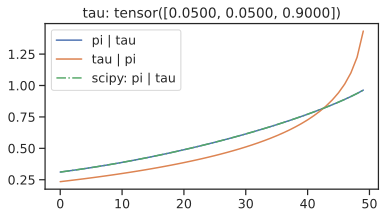

In [47]:
plt.title(f'tau: {human_policy}')
plt.plot(list(range(num_steps)), kl_div_list_tau_pi, label='pi | tau')
plt.plot(list(range(num_steps)), kl_div_list_pi_tau, label='tau | pi')
plt.plot(list(range(num_steps)), kl_scipy_list_pi_tau, label='scipy: pi | tau', linestyle='-.')
plt.legend();

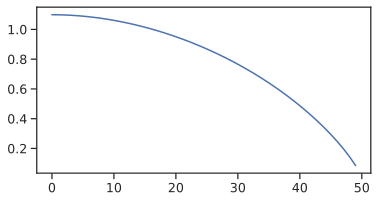

In [48]:
plt.plot(list(range(num_steps)), ent_values);

In [51]:
# IL policy
human_policy = torch.tensor([0.99, 0.005, 0.005])
pi_action_dist = torch.tensor([1/3, 1/3, 1/3])

# Define the target values
target_values = torch.tensor([0.999, 0.0005, 0.0005])

# Define the number of steps
num_steps = 50

ent_values = []
kl_div_list_pi_tau = []
kl_div_list_tau_pi = []
kl_scipy_list_pi_tau = []

# Compute the increment for each step
increments = (target_values - pi_action_dist) / num_steps

# Iterate for 20 steps
for _ in range(num_steps):
    
    ent_values.append(entropy(pi_action_dist))
    
    kl_mean_tau_pi = float(kl_div_torch_log(human_policy.log(), pi_action_dist.log()).numpy())
    kl_mean_pi_tau = float(kl_div_torch_log(pi_action_dist.log(), human_policy.log()).numpy())
    
    kl_div_list_pi_tau.append(kl_mean_pi_tau)
    kl_div_list_tau_pi.append(kl_mean_tau_pi)
    
    kl_mean_scipy_pi_tau = kl_div(pi_action_dist, human_policy).mean()
    kl_scipy_list_pi_tau.append(kl_mean_scipy_pi_tau)
    
    pi_action_dist += increments    
    
    print(pi_action_dist)

tensor([0.3466, 0.3267, 0.3267])
tensor([0.3600, 0.3200, 0.3200])
tensor([0.3733, 0.3134, 0.3134])
tensor([0.3866, 0.3067, 0.3067])
tensor([0.3999, 0.3000, 0.3000])
tensor([0.4132, 0.2934, 0.2934])
tensor([0.4265, 0.2867, 0.2867])
tensor([0.4398, 0.2801, 0.2801])
tensor([0.4532, 0.2734, 0.2734])
tensor([0.4665, 0.2668, 0.2668])
tensor([0.4798, 0.2601, 0.2601])
tensor([0.4931, 0.2535, 0.2535])
tensor([0.5064, 0.2468, 0.2468])
tensor([0.5197, 0.2401, 0.2401])
tensor([0.5330, 0.2335, 0.2335])
tensor([0.5463, 0.2268, 0.2268])
tensor([0.5597, 0.2202, 0.2202])
tensor([0.5730, 0.2135, 0.2135])
tensor([0.5863, 0.2069, 0.2069])
tensor([0.5996, 0.2002, 0.2002])
tensor([0.6129, 0.1935, 0.1935])
tensor([0.6262, 0.1869, 0.1869])
tensor([0.6395, 0.1802, 0.1802])
tensor([0.6529, 0.1736, 0.1736])
tensor([0.6662, 0.1669, 0.1669])
tensor([0.6795, 0.1603, 0.1603])
tensor([0.6928, 0.1536, 0.1536])
tensor([0.7061, 0.1469, 0.1469])
tensor([0.7194, 0.1403, 0.1403])
tensor([0.7327, 0.1336, 0.1336])
tensor([0.

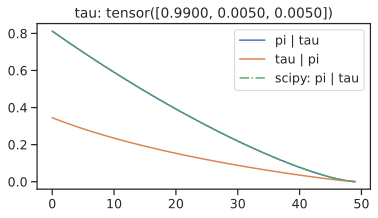

In [52]:
plt.title(f'tau: {human_policy}')
plt.plot(list(range(num_steps)), kl_div_list_tau_pi, label='pi | tau')
plt.plot(list(range(num_steps)), kl_div_list_pi_tau, label='tau | pi')
plt.plot(list(range(num_steps)), kl_scipy_list_pi_tau, label='scipy: pi | tau', linestyle='-.')
plt.legend();

In [134]:
float(kl_div_torch_log(pi_action_dist.log(), human_policy.log()).numpy())

0.23473821580410004